Questions: Which time of the year is the busiest and how does it affect the prices?
    

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Union
import matplotlib.axes
from stop_words import safe_get_stop_words
from wordcloud import WordCloud
import plotly.express as px


%matplotlib inline

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# pd.options.plotting.backend = 'plotly'



In [2]:
# some_file.py
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../src/')

from utils import plot_multi

In [3]:
df = pd.read_csv('../data/seattle/calendar.csv')
#Quick glimpse at the data
df.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [4]:
#Size of the data set
df.shape

(1393570, 4)

In [5]:
#Looks like we have to transform the columns to the appropriate data types
df.dtypes

listing_id     int64
date          object
available     object
price         object
dtype: object

In [6]:
#Check if any values are missing. Luckily only some prices are missing due to availability
df.isnull().sum()

listing_id         0
date               0
available          0
price         459028
dtype: int64

In [7]:
#Check if there are rows with price and no availability or vice versa
df[(df['available']=='t') & pd.isna(df['price'])]

,listing_id,date,available,price


In [8]:
df[(df['available']=='f') & (pd.isna(df['price'])==False)]

,listing_id,date,available,price


In [9]:
#Check how many unique values in each column
df.nunique()

listing_id    3818
date           365
available        2
price          669
dtype: int64

In [10]:
#Check if every listing has the same number of dates.
df.groupby('listing_id')['date'].count().unique()

array([365])

Looks like the data set is very clean and well pepared. Now we should convert the 'date', 'available' and 'price' columns to the appropriate data types.

In [11]:
bool_mapping = {'t':True, 'f':False}

df['available'] = df['available'].map(bool_mapping) 
df['date'] = pd.to_datetime(df['date'])
df['price'] = df['price'].replace('[$,]', '', regex=True).astype(float)

df.dtypes

listing_id             int64
date          datetime64[ns]
available               bool
price                float64
dtype: object

Now we are ready to do some analysis

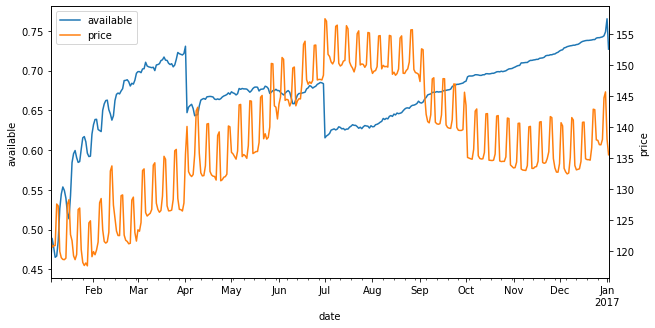

In [12]:
#Let's take a look at daily averaged values data.

daily_df = (df.groupby('date').agg({'available':  'mean',
                                    'price': 'mean'}))

# cols = ["_".join(pair) for pair in daily_df.columns]
# daily_df.droplevel(0,axis=1).head()
# daily_df.columns = cols
daily_df = daily_df.reset_index()

plot_multi(daily_df, x='date', y=['available','price'], figsize=(10, 5));


This looks odd. Looks like a bunch of listings become unavailable approx. on the 1st of April and on the 1st of July. The data file "listings" has a column "last_scraped" with the value Jan 4th 2016. I assume that the file "calendar" was scraped at the same date. Considering this the data makes sense, since Airbnb has an option for the hosts to open a booking calendar for 3, 6 or 12 months in the future. So those listings are not booked, they are just not available for booking at the beginning of the year.

The fact, that the booking calendar was scraped in the beginning of the year makes the pricing and availability data less interesting since those will change drastically as the year passes.

Another thing that strikes the eye is that the price oscilates on a weekly basis. I assume that the prices are higher on the weekend. 

The average price is higher in the summer than in the winter. However, it does not come down to the same level by the end of the year. I would not read too much into it because it is not the final data. Airbnb also has an option for the hosts to adjust the price automatically based on current demand.

In [13]:
#Let's exclude the listing with partial availability calendars and look at the data again.

#Check on which 2 dates are the 2 big drops in availability.
(df[df['available']==True].groupby('listing_id')
                          .agg({'date':'max'})
                          .groupby('date')
                          .agg(count=('date','count'))
                          .sort_values(by='count', ascending=False)
                          .head()
)

,count
date,
2017-01-02,2776
2016-04-01,306
2016-06-30,249
2017-01-01,155
2016-12-31,15


In [14]:
#Get the latest available date for each listing
last_avail_df = (df[df['available']==True].groupby('listing_id').agg({'date':'max'}))

#Listings which are not limited to 3 or 6 months availability
last_avail_eoy_df = last_avail_df[(last_avail_df['date']!= '2016-04-01') & (last_avail_df['date']!= '2016-06-30')]

eoy_listings = last_avail_eoy_df.index.to_list()

#Exclude the listing which are limited to 3 or 6 months availability an plot a daily chart.

eoy_df = df[df['listing_id'].isin(eoy_listings)]


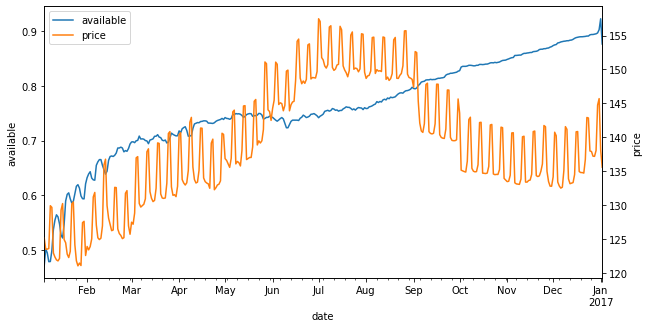

In [15]:
#Calculate daily averages
daily_eoy_df = (eoy_df.groupby('date').agg({'available':'mean',
                                            'price': 'mean'}))

# cols = ["_".join(pair) for pair in daily_eoy_df.columns]
# daily_eoy_df.droplevel(0,axis=1).head()
# daily_eoy_df.columns = cols
daily_eoy_df = daily_eoy_df.reset_index()

plot_multi(daily_eoy_df, x='date', y=['available','price'], figsize=(10, 5));

It looks much smoother now. The availability plot still does not tell us which time of the year is the busiest since the data was scraped in the beginning of the year. The plot goes more or less asympoticalle against 1 with a slight dip in the summer months.

One can also see that the availability oscilates on the the weekly basis but the further in to the future the smaller this oscilation becomes until it is not visible anymore. I assume that in the near furure there are more short term bookings on the weekends which is not the case if we look at the data 6+ months in the future.

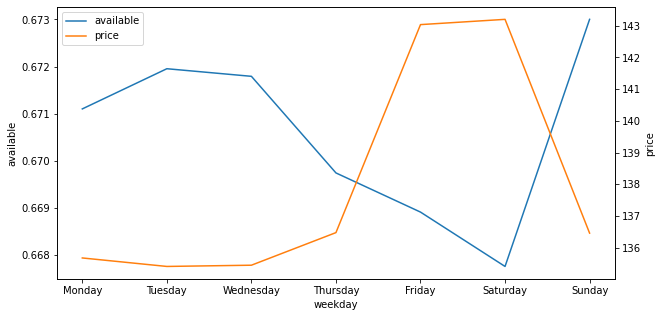

In [16]:
weekday_df = (df.groupby(df['date'].dt.weekday)
                           .agg({'available':  'mean',
                                 'price': 'mean'}))


# cols = ["_".join(pair) for pair in weekday_df.columns]
# weekday_df.droplevel(0,axis=1)
# weekday_df.columns = cols
weekday_df = weekday_df.reset_index()
weekday_df['weekday'] = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']

plot_multi(weekday_df, x='weekday', y=['available','price'], figsize=(10, 5));

As expected the prices are highest and availability is lowest on the weekends. This is just a qualitative check since the data is not final.

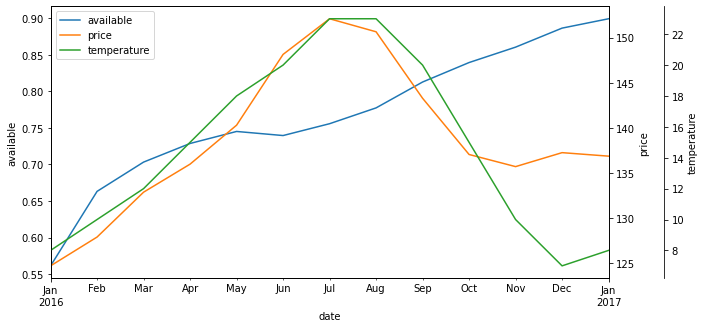

In [17]:
#Additionally we can look at the monthly averaged values and add the average air temperature in Seattle to the chart.
monthly_df = (daily_eoy_df.groupby([pd.Grouper(key='date', freq='MS', sort=True, label='left', closed='left')])
                           .agg({'available':  'mean',
                                 'price': 'mean'}))

monthly_df = monthly_df.reset_index()
monthly_df['temperature'] = [8, 10, 12, 15, 18, 20, 23, 23, 20, 15, 10, 7, 8] #Source: NOAA

plot_multi(monthly_df, x='date', y=['available','price', 'temperature'], figsize=(10, 5));

It is amazing how close does the price chart follows the temperature for the first 10 months.

In [18]:
df2_cols_to_drop = ['listing_url',
                    'scrape_id',
                    'last_scraped',
                    'experiences_offered',
                    'thumbnail_url',
                    'medium_url',
                    'picture_url',
                    'xl_picture_url',
                    'host_id',
                    'host_url',
                    'host_name',
                    'host_thumbnail_url',
                    'host_picture_url',
                    'market',
                    'country_code',
                    'country',
                    'latitude',
                    'longitude',
                    'price',
                    'weekly_price',
                    'monthly_price',
                    'security_deposit',
                    'cleaning_fee',
                    'extra_people',
                    'has_availability',
                    'calendar_last_scraped'
                    'jurisdiction_names']